# Libraries & Data

In [1]:
# !pip install numpy==1.23.5
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install nltk
# !pip install emoji
# !pip install -U keras-tuner
# !pip install tensorflow
# !pip install kaggle
# !pip install -U spacy
# !pip install gensim
#
# !rm -r KT_dir_2

In [123]:
import nltk
import tensorflow as tf
import keras_tuner as kt
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, json, re, time, emoji, kaggle, string, locale
from tqdm import tqdm
import gensim.downloader as api


from spacy.lang.en.stop_words import STOP_WORDS

from nltk.tag.perceptron import PerceptronTagger
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve,
    auc,
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
)
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Layer, Embedding, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.layers import TextVectorization

In [125]:
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
#
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# nltk.download("averaged_perceptron_tagger")
# nltk.download('averaged_perceptron_tagger_eng')

In [10]:
# !python -m spacy download en_core_web_sm

In [11]:
# Ensure the Kaggle directory exists
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Copy kaggle.json to the right location if it is not already there
# Uncomment and modify the below lines if you need to place your kaggle.json file in the right directory
# import shutil
# shutil.copy('path_to_your_kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))

# Download the dataset using Kaggle API
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
twitter-entity-sentiment-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username": "{username}", "key": "{key}"}

with open("/Users/antonal/.kaggle/kaggle.json", "w") as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: /Users/antonal/.kaggle: File exists


In [125]:
kaggle.api.authenticate()
kaggle.api.competition_download_files("twitter-sentiment-analysis2")

In [125]:
!unzip twitter-sentiment-analysis2.zip

### Initialise dataset

In [15]:
# Read the CSV file 'train.csv', selecting only the 'Sentiment' and 'SentimentText' columns.
df_tweet_sentiment = pd.read_csv(
    "./train.csv",
    encoding="ISO-8859-1",
    usecols=["Sentiment", "SentimentText"],
    index_col=False,
)

# Filtering the DataFrame to get the first 5000 rows where the sentiment is 0 (negative)
df_negative_tweets = df_tweet_sentiment[df_tweet_sentiment["Sentiment"] == 0].head(5000)

# Filtering the DataFrame to get the first 5000 rows where the sentiment is 1 (positive)
df_positive_tweets = df_tweet_sentiment[df_tweet_sentiment["Sentiment"] == 1].head(5000)

# Concatenate the two filtered DataFrames into a single DataFrame
df_tweet_sentiment = pd.concat([df_negative_tweets, df_positive_tweets])

# Shuffle the concatenated DataFrame randomly and reset the index
df_tweet_sentiment = df_tweet_sentiment.sample(frac=1).reset_index(drop=True)
df_tweet_sentiment

,Sentiment,SentimentText
0,1,#mygarage - new hashtag for the interesting ri...
1,0,#Haveyouever why you and your mom just can't g...
2,0,#BGT That poor kid
3,1,#haveyouever had cream cheese &amp; french fri...
4,1,=- trying to figure out this Twitter thingie
...,...,...
9995,0,not even one single reply.what are people loo...
9996,1,#phish has an awesome fog machine. oh wait. n...
9997,1,gotta love her. glad she had fun. looking for...
9998,1,&quot;I'm wore out like the waist band on some...


In [16]:
# Initialize a WordNetLemmatizer, which is used to reduce words to their base or root form, e.g., (churches -> church, abaci -> abacus)
lemmatizer = WordNetLemmatizer()

# Initialize a PerceptronTagger, which is a part-of-speech tagger used to label words with their corresponding parts of speech
tagger = PerceptronTagger()

# Initialize a TweetTokenizer, which is specifically designed to handle tokenizing tweets (short text with special characters and emoticons)
tweet_wt = TweetTokenizer()

# Preprocess dataset

In [17]:
# Lemmatization helper function
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None

In [18]:
def replace_special_tokens(sequence):
    # Replace URLs with the token "<url>"
    sequence = re.sub(
        """http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]
        [0-9a-fA-F]))+""",
        "<url>",
        sequence,
    )

    # Replace mentions (words starting with @) with the token "<user>"
    sequence = re.sub("@\S+", "<user>", sequence)

    # Replace hashtags (words starting with #) with the token "<hashtag>"
    sequence = re.sub("#\S+", "<hashtag>", sequence)

    # Replace numbers (including decimals) with the token "<number>"
    sequence = re.sub("([+-]?([0-9]+([.][0-9]*)?|[.][0-9]+))", "<number>", sequence)

    # Convert emojis to text representation (e.g., 😊 to :smiling_face_with_smiling_eyes:)
    sequence = emoji.demojize(sequence)  # remove emojis

    # Remove emoticons (represented as :word:) from the sequence
    sequence = re.sub(r"\s*:[\w]+", " ", sequence)  # remove emoticons

    # Convert the entire sequence to lowercase
    sequence = sequence.lower()

    return sequence

In [19]:
# Apply the replace_special_tokens function to the 'SentimentText' column to preprocess the text
df_tweet_sentiment["processed_text"] = df_tweet_sentiment["SentimentText"].apply(
    replace_special_tokens
)

# Tokenize the processed text using the TweetTokenizer
df_tweet_sentiment["tokenized_text"] = df_tweet_sentiment["processed_text"].apply(
    lambda x: tweet_wt.tokenize(x)
)

# Tag the tokenized text with part-of-speech tags using the PerceptronTagger
df_tweet_sentiment["text_tags"] = df_tweet_sentiment["tokenized_text"].apply(
    lambda x: tagger.tag(x)
)
df_tweet_sentiment

,Sentiment,SentimentText,processed_text,tokenized_text,text_tags
0,1,#mygarage - new hashtag for the interesting ri...,<hashtag> - new hashtag for the interesting ri...,"[<hashtag>, -, new, hashtag, for, the, interes...","[(<hashtag>, SYM), (-, :), (new, JJ), (hashtag..."
1,0,#Haveyouever why you and your mom just can't g...,<hashtag> why you and your mom just can't get ...,"[<hashtag>, why, you, and, your, mom, just, ca...","[(<hashtag>, JJ), (why, WRB), (you, PRP), (and..."
2,0,#BGT That poor kid,<hashtag> that poor kid,"[<hashtag>, that, poor, kid]","[(<hashtag>, NN), (that, WDT), (poor, JJ), (ki..."
3,1,#haveyouever had cream cheese &amp; french fri...,<hashtag> had cream cheese &amp; french fries ...,"[<hashtag>, had, cream, cheese, &, french, fri...","[(<hashtag>, NN), (had, VBD), (cream, VBN), (c..."
4,1,=- trying to figure out this Twitter thingie,=- trying to figure out this twitter thingie,"[=, -, trying, to, figure, out, this, twitter,...","[(=, SYM), (-, :), (trying, VBG), (to, TO), (f..."
...,...,...,...,...,...
9995,0,not even one single reply.what are people loo...,not even one single reply.what are people loo...,"[not, even, one, single, reply.what, are, peop...","[(not, RB), (even, RB), (one, CD), (single, JJ..."
9996,1,#phish has an awesome fog machine. oh wait. n...,<hashtag> has an awesome fog machine. oh wait....,"[<hashtag>, has, an, awesome, fog, machine, .,...","[(<hashtag>, NN), (has, VBZ), (an, DT), (aweso..."
9997,1,gotta love her. glad she had fun. looking for...,gotta love her. glad she had fun. looking for...,"[gotta, love, her, ., glad, she, had, fun, ., ...","[(gotta, NN), (love, VB), (her, PRP$), (., .),..."
9998,1,&quot;I'm wore out like the waist band on some...,&quot;i'm wore out like the waist band on some...,"["", i'm, wore, out, like, the, waist, band, on...","[("", JJ), (i'm, NN), (wore, VBD), (out, RP), (..."


In [20]:
# Function to lemmatize a sequence of tokens with POS tags
def lemma(sequence):
    return [
        lemmatizer.lemmatize(token, pos=nltk_pos_tagger(pos_tag))
        if nltk_pos_tagger(pos_tag) != None
        else lemmatizer.lemmatize(token)
        for token, pos_tag in sequence
    ]

In [21]:
# Apply the lemma function to the 'text_tags' column of the dataframe
# 'text_tags' is assumed to be a list of (token, pos_tag) tuples for each tweet
df_tweet_sentiment["lemmatized_text"] = df_tweet_sentiment["text_tags"].apply(
    lambda x: lemma(x)
)

In [22]:
# Apply a lambda function to the 'lemmatized_text' column of the dataframe
# This lambda function joins the list of lemmatized tokens into a single string
# Each token is separated by a space
df_tweet_sentiment["lemmatized_text_joined"] = df_tweet_sentiment[
    "lemmatized_text"
].apply(lambda x: " ".join(x))
df_tweet_sentiment

,Sentiment,SentimentText,processed_text,tokenized_text,text_tags,lemmatized_text,lemmatized_text_joined
0,1,#mygarage - new hashtag for the interesting ri...,<hashtag> - new hashtag for the interesting ri...,"[<hashtag>, -, new, hashtag, for, the, interes...","[(<hashtag>, SYM), (-, :), (new, JJ), (hashtag...","[<hashtag>, -, new, hashtag, for, the, interes...",<hashtag> - new hashtag for the interesting ri...
1,0,#Haveyouever why you and your mom just can't g...,<hashtag> why you and your mom just can't get ...,"[<hashtag>, why, you, and, your, mom, just, ca...","[(<hashtag>, JJ), (why, WRB), (you, PRP), (and...","[<hashtag>, why, you, and, your, mom, just, ca...",<hashtag> why you and your mom just can't get ...
2,0,#BGT That poor kid,<hashtag> that poor kid,"[<hashtag>, that, poor, kid]","[(<hashtag>, NN), (that, WDT), (poor, JJ), (ki...","[<hashtag>, that, poor, kid]",<hashtag> that poor kid
3,1,#haveyouever had cream cheese &amp; french fri...,<hashtag> had cream cheese &amp; french fries ...,"[<hashtag>, had, cream, cheese, &, french, fri...","[(<hashtag>, NN), (had, VBD), (cream, VBN), (c...","[<hashtag>, have, cream, cheese, &, french, fr...",<hashtag> have cream cheese & french fry ( sen...
4,1,=- trying to figure out this Twitter thingie,=- trying to figure out this twitter thingie,"[=, -, trying, to, figure, out, this, twitter,...","[(=, SYM), (-, :), (trying, VBG), (to, TO), (f...","[=, -, try, to, figure, out, this, twitter, th...",= - try to figure out this twitter thingie
...,...,...,...,...,...,...,...
9995,0,not even one single reply.what are people loo...,not even one single reply.what are people loo...,"[not, even, one, single, reply.what, are, peop...","[(not, RB), (even, RB), (one, CD), (single, JJ...","[not, even, one, single, reply.what, be, peopl...",not even one single reply.what be people look ...
9996,1,#phish has an awesome fog machine. oh wait. n...,<hashtag> has an awesome fog machine. oh wait....,"[<hashtag>, has, an, awesome, fog, machine, .,...","[(<hashtag>, NN), (has, VBZ), (an, DT), (aweso...","[<hashtag>, have, an, awesome, fog, machine, ....",<hashtag> have an awesome fog machine . oh wai...
9997,1,gotta love her. glad she had fun. looking for...,gotta love her. glad she had fun. looking for...,"[gotta, love, her, ., glad, she, had, fun, ., ...","[(gotta, NN), (love, VB), (her, PRP$), (., .),...","[gotta, love, her, ., glad, she, have, fun, .,...",gotta love her . glad she have fun . look forw...
9998,1,&quot;I'm wore out like the waist band on some...,&quot;i'm wore out like the waist band on some...,"["", i'm, wore, out, like, the, waist, band, on...","[("", JJ), (i'm, NN), (wore, VBD), (out, RP), (...","["", i'm, wear, out, like, the, waist, band, on...",""" i'm wear out like the waist band on some old..."


In [23]:
x_train, x_test, y_train, y_test = train_test_split(
    df_tweet_sentiment["lemmatized_text_joined"],
    df_tweet_sentiment["Sentiment"],
    test_size=0.2,
    random_state=23828748,
)
print("Training texts:", len(x_train))
print("Testing texts:", len(x_test))

Training texts: 8000
Testing texts: 2000


# TF-Idf Vectorizer

In [24]:
# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words=stopwords.words("english"),
)

In [25]:
# Fit Vectorizer on train data
# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

print(vectorizer.get_feature_names_out()[:10])

['abit' 'able' 'able get' 'able go' 'absolutely' 'abt' 'ac' 'accent'
 'accident' 'accord']


In [26]:
print("Shape of training data: {}".format(x_train_tfidf.shape))
print("Shape of test data: {}\n".format(x_test_tfidf.shape))

Shape of training data: (8000, 5000)
Shape of test data: (2000, 5000)



In [27]:
# sparse matrix --> Saves only the cells where tf*idf is not zero
print(type(x_test_tfidf))
print(x_test_tfidf[0, :])

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 981)	0.2610531758549099
  (0, 1751)	0.25554243762248685
  (0, 1828)	0.5442627260277735
  (0, 1973)	0.19380063494342722
  (0, 2777)	0.3761954790174606
  (0, 3286)	0.3705922776538255
  (0, 3364)	0.33761772231426157
  (0, 4306)	0.29730987577023926
  (0, 4637)	0.17434063328693597
  (0, 4648)	0.14537359164051272


# Baseline

In [28]:
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy="most_frequent")
start_time = time.time()
baseline.fit(x_train_tfidf, y_train)
print("Training took: {} seconds \n".format(time.time() - start_time))

Training took: 0.0008039474487304688 seconds 



In [29]:
# Evaluate
predictions = baseline.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
print("Train accuracy: {:.2f}%".format(score * 100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
print("Test accuracy: {:.2f}% \n".format(score * 100))

print("#Class 0 in Train dataset:", np.where(y_train == 0)[0].shape)
print("#Class 1 in Train dataset:", np.where(y_train == 1)[0].shape)

Train accuracy: 50.25%
Test accuracy: 49.00% 

#Class 0 in Train dataset: (4020,)
#Class 1 in Train dataset: (3980,)


In [30]:
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4020
           1       0.00      0.00      0.00      3980

    accuracy                           0.50      8000
   macro avg       0.25      0.50      0.33      8000
weighted avg       0.25      0.50      0.34      8000



/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       980
           1       0.00      0.00      0.00      1020

    accuracy                           0.49      2000
   macro avg       0.24      0.50      0.33      2000
weighted avg       0.24      0.49      0.32      2000



/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/antonal/ta2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Confusion Matrix for test data:


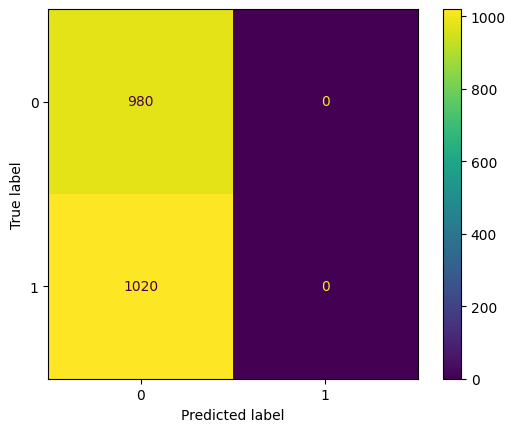

In [32]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(
    baseline, x_test_tfidf, y_test, values_format=".0f"
)

# Logistic Regression

In [33]:
# Cross Validation Logistic Regression
# Fit the model with CV
log_cv = LogisticRegressionCV(
    cv=3, Cs=8, random_state=2, penalty="l2", solver="liblinear"
).fit(x_train_tfidf, y_train)
# Score
log_cv.score(x_test_tfidf, y_test)

0.752

In [34]:
predictions = log_cv.predict(x_train_tfidf)
score = f1_score(y_train, predictions)

In [35]:
predictions_test = log_cv.predict(x_test_tfidf)
score_pred = f1_score(y_test, predictions_test)

In [36]:
print("Train f1-score: {:.2f}% \n".format(score * 100))
print("Classification Report for TRAIN data set:")
print(classification_report(y_train, predictions))

Train f1-score: 89.71% 

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4020
           1       0.90      0.90      0.90      3980

    accuracy                           0.90      8000
   macro avg       0.90      0.90      0.90      8000
weighted avg       0.90      0.90      0.90      8000



In [37]:
print("Test f1-score: {:.2f}% \n".format(score_pred * 100))
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test))

Test f1-score: 75.73% 

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       980
           1       0.76      0.76      0.76      1020

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000




Confusion Matrix for test data:


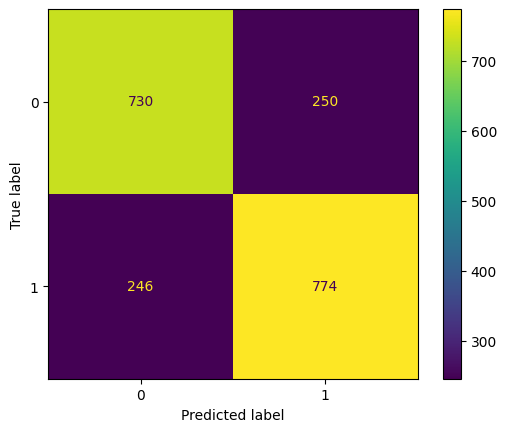

In [38]:
print("\nConfusion Matrix for test data:")
ConfusionMatrixDisplay.from_estimator(log_cv, x_test_tfidf, y_test, values_format=".0f")

# MLP text classifier in Keras with centroids word embeddings

In [39]:
X_train_new, X_val, y_train_new, y_val = train_test_split(
    x_train, y_train, test_size=1 / 8, random_state=23828748
)

In [65]:
# Convert with Keras
y_train_1_hot = tf.keras.utils.to_categorical(
    y_train_new, num_classes=len(y_train_new.unique())
)  # 7000

y_val_1_hot = tf.keras.utils.to_categorical(
    y_val, num_classes=len(y_val.unique())
)  # 1000

y_test_1_hot = tf.keras.utils.to_categorical(
    y_test, num_classes=len(y_test.unique())
)  # 2000


y_train_old_1_hot = tf.keras.utils.to_categorical(
    y_train, num_classes=len(y_train.unique())
)  # 8000

In [41]:
# Download and load Google news embeddings
wv = api.load("glove-twitter-100")

## Calculate centroids

In [42]:
# Define a function to calculate the centroid of a text document
def text_centroid(text, model):
    text = text.split()  # Split the text into individual words
    text_vec = []        # Initialize an empty list to store word vectors
    counter = 0          # Counter to keep track of valid words (non-stopwords)

    # Iterate through each word in the text
    for word in text:
        if word in STOP_WORDS:  # Skip stopwords (commonly used words that do not provide useful information)
            continue
        try:
            if counter == 0:
                # Get the word vector for the first valid word (in lowercase)
                text_vec = model[word.lower()]
            else:
                # Add the word vector for the current word to the running sum
                text_vec = np.add(text_vec, model[word.lower()])
            counter += 1  # Increment the valid word counter
        except:  # Skip words that are not in the model's vocabulary
            pass

    # If no valid words were found, return a zero vector
    if counter == 0:
        return np.zeros(model.vector_size)

    # Return the average of the word vectors (centroid) by dividing the sum by the counter
    return np.asarray(text_vec) / counter

In [43]:
# Calculate centroids for the training documents
X_train_centroids = []
for sentence in X_train_new:
    X_train_centroids.append(text_centroid(sentence, wv))  # Calculate the centroid for each sentence
X_train_centroids = np.stack(X_train_centroids, axis=0)    # Convert the list of centroids to a NumPy array

# Calculate centroids for the validation documents
X_val_centroids = []
for sentence in X_val:
    X_val_centroids.append(text_centroid(sentence, wv))     # Calculate centroids for validation data
X_val_centroids = np.stack(X_val_centroids, axis=0)         # Convert to a NumPy array

# Calculate centroids for the test documents
X_test_centroids = []
for sentence in x_test:
    X_test_centroids.append(text_centroid(sentence, wv))    # Calculate centroids for test data
X_test_centroids = np.stack(X_test_centroids, axis=0)       # Convert to a NumPy array

In [45]:
# Define a custom callback class Metrics that inherits from tf.keras.callbacks.Callback
class Metrics(tf.keras.callbacks.Callback):
    # Initialize the class with validation data
    def __init__(self, valid_data):
        # Call the parent class's initializer
        super(Metrics, self).__init__()
        # Store the validation data
        self.validation_data = valid_data

    # This method is called at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        # If logs dictionary is not provided, initialize it as an empty dictionary
        logs = logs or {}
        # Predict the output for validation data and take the class with the highest probability
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        # Get the actual validation targets
        val_targ = self.validation_data[1]
        # Cast the validation targets to float32 type
        val_targ = tf.cast(val_targ, dtype=tf.float32)
        # If the validation targets are one-hot encoded, convert them to label encoded
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        # Calculate the weighted F1 score
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        # Calculate the weighted recall
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        # Calculate the weighted precision
        _val_precision = precision_score(val_targ, val_predict, average="weighted")

        # Log the calculated metrics
        logs["val_f1"] = _val_f1
        logs["val_recall"] = _val_recall
        logs["val_precision"] = _val_precision
        # Print the calculated metrics
        print(
            " — val_f1: %f — val_precision: %f — val_recall: %f"
            % (_val_f1, _val_precision, _val_recall)
        )
        return

In [46]:
# Define a new Sequential model
model2 = Sequential()

# Add the first dense (fully connected) layer with 1024 units and ReLU activation
# The input dimension is set to the number of features in the centroid vectors (X_train_centroids)
model2.add(Dense(1024, input_dim=X_train_centroids.shape[1], activation="relu"))

# Add a Dropout layer to reduce overfitting with a dropout rate of 0.3 (30% of neurons dropped)
model2.add(Dropout(0.3))

# Add a second dense layer with 1024 units and ReLU activation
model2.add(Dense(1024, activation="relu"))

# Add another Dropout layer with a 30% dropout rate
model2.add(Dropout(0.3))

# Add a third dense layer with 512 units and ReLU activation
model2.add(Dense(512, activation="relu"))

# Add another Dropout layer with a 30% dropout rate
model2.add(Dropout(0.3))

# Add the output layer with a softmax activation to classify into the number of unique classes
# The number of units in the output layer matches the number of unique classes in the target
model2.add(Dense(len(y_train_new.unique()), activation="softmax"))

# Print the model summary to display the structure and layers of the model
print(model2.summary())

# Compile the model with categorical cross-entropy as the loss function, Adam optimizer, and categorical accuracy metric
model2.compile(
    loss="categorical_crossentropy",            # Loss function for multi-class classification
    optimizer=Adam(learning_rate=0.001),        # Adam optimizer with a learning rate of 0.001
    metrics=[CategoricalAccuracy()],            # Use categorical accuracy as the evaluation metric
)

# Define an EarlyStopping callback to stop training if the validation loss doesn't improve for 20 epochs
early_stopping = EarlyStopping(patience=20, verbose=2, restore_best_weights=True)

# Train the model using the training centroid vectors and one-hot encoded labels
history2 = model2.fit(
    X_train_centroids,               # Training feature set (centroid vectors)
    y_train_1_hot,                   # Training labels (one-hot encoded)
    validation_data=(X_val_centroids, y_val_1_hot),  # Validation data (centroid vectors and labels)
    batch_size=256,                  # Batch size of 256
    epochs=100,                      # Maximum number of epochs to train
    shuffle=True,                    # Shuffle the training data at the start of each epoch
    callbacks=[
        Metrics(valid_data=(X_val_centroids, y_val_1_hot)),  # Custom metric callback for monitoring performance
        early_stopping,  # Apply early stopping to prevent overfitting and restore the best weights
    ],
)

/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │       103,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,678,850 (6.40 MB)

 Trainable params: 1,678,850 (6.40 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
 — val_f1: 0.731704 — val_precision: 0.749755 — val_recall: 0.734000
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - categorical_accuracy: 0.6159 - loss: 0.6419 - val_categorical_accuracy: 0.7340 - val_loss: 0.5251 - val_f1: 0.7317 - val_recall: 0.7340 - val_precision: 0.7498
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepp - categ
 — val_f1: 0.746784 — val_precision: 0.751444 — val_recall: 0.747000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - categorical_accuracy: 0.7637 - loss: 0.4929 - val_categorical_accuracy: 0.7470 - val_loss: 0.4896 - val_f1: 0.7468 - val_recall: 0.7470 - val_precision: 0.7514
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepp - categ
 — val_f1: 0.741275 — val_precision: 0.749680 — val_recall: 0.742000
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - categorical_accuracy: 0.7749 - loss: 0.4640 - val_categorical_accuracy: 0.7420 - val_loss: 0.4960 - val_f1: 0.7413 - val_recall: 0.7420 - val_precision: 0.7497
Epoch 4/100

# Visualize Model's Training History

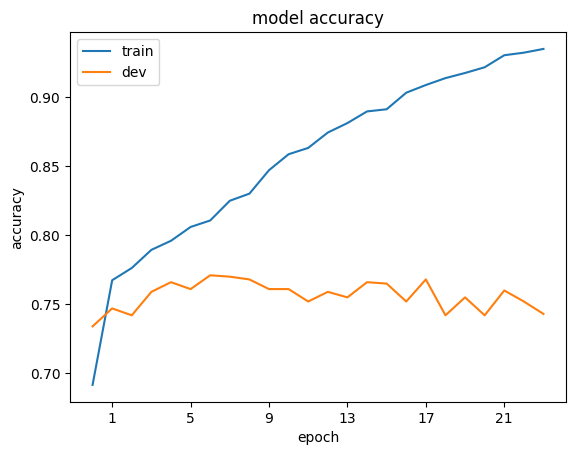

In [47]:
# summarize history for accuracy
plt.plot(history2.history["categorical_accuracy"])
plt.plot(history2.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper left")
plt.xticks(range(1, len(history2.history["categorical_accuracy"]) + 1, 4))
plt.show()

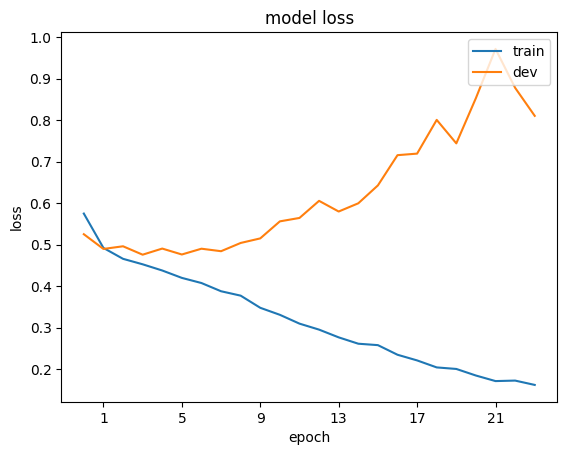

In [48]:
# summarize history for loss
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "dev"], loc="upper right")
plt.xticks(range(1, len(history2.history["loss"]) + 1, 4))
plt.show()

In [50]:
# create checkpoint dir if not exists
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

# Save model & weights
model2.save("checkpoints/MLP_centroids.keras")

In [51]:
# load weights and model from the saved checkpoint
centroids_model = load_model("checkpoints/MLP_centroids.keras")

In [52]:
# Predict the class labels for the test data using model2 (centroid-based model)
predictions = np.argmax(model2.predict(X_test_centroids), -1)

# Print a classification report comparing the true labels and predicted labels for the test set
print(classification_report(y_test, predictions))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       980
           1       0.79      0.77      0.78      1020

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



# RNN GRU text classifier

We need to tokenize our dataset so we can use the tokenized data in order to build the padding and the embedded vocabulary that we will use in the RNN GRU

In [86]:
def is_number(s):
    # Try to convert the input to a float
    try:
        float(s)
        return True
    except ValueError:
        # If a ValueError is raised, the input is not a number
        return False

In [87]:
# Load the English language model from Spacy, disabling the tagger, parser, named entity recognizer, and lemmatizer components
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner", "lemmatizer"])

# Add the sentencizer component to the pipeline. This component is responsible for splitting the text into sentences
nlp.add_pipe('sentencizer')

In [97]:
# Initialize an empty list to store the tokenized training data
X_train_tokenized = []

# Loop over each item in the training data
for idx in tqdm(range(len(X_train_new))):
  # Parse the text with Spacy
  doc = nlp(X_train_new.iloc[idx])
  # Initialize an empty list to store the tokens for this document
  tokens = []
  # Loop over each sentence in the document
  for sent in doc.sents:
    # Loop over each token in the sentence
    for tok in sent:
      # If the token is a newline, tab, double dash, asterisk, stop word, punctuation, all punctuation, or a number, skip it
      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or\
       tok.text.lower() in STOP_WORDS or tok.text in string.punctuation or\
        all(x in string.punctuation for x in tok.text) or is_number(tok.text):
        continue
      # If the token is not empty, add it to the list of tokens for this document
      if tok.text.strip():
        tokens.append(tok.text.replace('"',"'").strip().lower())
  # Add the list of tokens for this document to the list of tokenized training data
  X_train_tokenized.append(tokens)

100%|██████████| 7000/7000 [00:12<00:00, 563.90it/s]


In [89]:
# Loop over each item in the training data
X_val_tokenized = []

# Loop over each item in the training data
for idx in tqdm(range(len(X_val))):
  # Parse the text with Spacy
  doc = nlp(X_val.iloc[idx])
  # Initialize an empty list to store the tokens for this document
  tokens = []
  # Loop over each sentence in the document
  for sent in doc.sents:
    # Loop over each token in the sentence
    for tok in sent:
      # If the token is a newline, tab, double dash, asterisk, stop word, punctuation, all punctuation, or a number, skip it
      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or\
       tok.text.lower() in STOP_WORDS or tok.text in string.punctuation or\
        all(x in string.punctuation for x in tok.text) or is_number(tok.text):
        continue
      # If the token is not empty, add it to the list of tokens for this document
      if tok.text.strip():
        tokens.append(tok.text.replace('"',"'").strip().lower())
  # Add the list of tokens for this document to the list of tokenized validation data
  X_val_tokenized.append(tokens)

100%|██████████| 1000/1000 [00:01<00:00, 524.42it/s]


In [90]:
X_test_tokenized = []

# Loop over each item in the training data
for idx in tqdm(range(len(x_test))):
  # Parse the text with Spacy
  doc = nlp(x_test.iloc[idx])
  # Initialize an empty list to store the tokens for this document
  tokens = []
  # Loop over each sentence in the document
  for sent in doc.sents:
    # Loop over each token in the sentence
    for tok in sent:
      # If the token is a newline, tab, double dash, asterisk, stop word, punctuation, all punctuation, or a number, skip it
      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or\
       tok.text.lower() in STOP_WORDS or tok.text in string.punctuation or\
        all(x in string.punctuation for x in tok.text) or is_number(tok.text):
        continue
      # If the token is not empty, add it to the list of tokens for this document
      if tok.text.strip():
        tokens.append(tok.text.replace('"',"'").strip().lower())
  # Add the list of tokens for this document to the list of tokenized testing data
  X_test_tokenized.append(tokens)

100%|██████████| 2000/2000 [00:03<00:00, 517.96it/s]


### Vocabulary Creation

In [91]:
# Define the maximum number of words to keep, based on word frequency
MAX_WORDS = 512

# Define the maximum length of each sequence
MAX_SEQUENCE_LENGTH = 256

# Define the dimension of the dense embedding
EMBEDDING_DIM = 100

In [98]:
# Create a TextVectorization layer
# This layer transforms strings into integer representations that can be read by an Embedding layer
vectorizer = TextVectorization(max_tokens=MAX_WORDS, output_mode='int', ngrams=1,
              output_sequence_length=MAX_SEQUENCE_LENGTH)

# Adapt the vectorizer to the text data
vectorizer.adapt([" ".join(x) for x in X_train_tokenized])

# Use the vectorizer to transform the 15th document in X_train_tokenized into integer representations
# Then print each word in the document along with its corresponding integer representation
for widx, word in zip(vectorizer(' '.join(X_train_tokenized[14])).numpy().tolist(),X_train_tokenized[14]):
    print((widx,word))

(20, 'feel')
(1, 'shallow')
(1, 'breath')
(1, 'squeeze')
(1, 'past')
(1, 'pound')
(1, 'stone')
(1, 'laid')
(1, 'chest')


In [105]:
# Initialize an embedding matrix with zeros
# The number of rows is equal to the maximum number of words in the vocabulary (MAX_WORDS)
# The number of columns is equal to the dimension of the word vectors (100 in this case)
embedding_matrix = np.zeros(shape=(MAX_WORDS, 100))

# Enumerate over the vocabulary obtained from the vectorizer
# w2idx is the index of the word in the vocabulary
# _word is the actual word string
for w2idx, _word in enumerate(vectorizer.get_vocabulary()):
    # Skip the first two tokens ('PAD' and 'UNK') as they do not have corresponding word vectors
    if w2idx < 2:
      continue
    try:
      # Try to get the word vector for the current word from the word2vec model (wv)
      # Assign this word vector to the corresponding row in the embedding matrix
      embedding_matrix[w2idx] = wv[_word]
    except KeyError:
      # If the word is not found in the word2vec model, catch the KeyError and continue to the next word
      continue

### BiGRU and deep self-attention

In [106]:
class SelfAttention(Layer):
  def __init__(self, mlp_layers=0, units=0, dropout_rate=0, return_attention=False, **kwargs):
    # Initialize the parent class
    super(SelfAttention, self).__init__(**kwargs)

    # Store the parameters
    self.mlp_layers = mlp_layers
    self.mlp_units = units
    self.return_attention = return_attention
    self.dropout_rate = dropout_rate

    # Build the MLP (Multi-Layer Perceptron) that will be used to compute the attention scores
    self.attention_mlp = self.build_mlp()

  def build_mlp(self):
    # Initialize the MLP
    mlp = Sequential()

    # Add the hidden layers
    for i in range(self.mlp_layers):
      mlp.add(Dense(self.mlp_units, activation='relu'))
      mlp.add(Dropout(self.dropout_rate))

    # Add the output layer
    mlp.add(Dense(1))

    return mlp

  def call(self, x, mask=None):
    # Compute the attention scores
    a = self.attention_mlp(x)
    a = tf.squeeze(a, axis=2)

    # Apply the mask if provided
    if mask is not None:
      mask = tf.keras.backend.cast(mask, tf.keras.backend.floatx())
      a -= 100000.0 * (1.0 - mask)

    # Compute the softmax of the attention scores
    a = tf.keras.backend.expand_dims(tf.keras.backend.softmax(a, axis=-1))

    # Compute the weighted sum of the inputs according to the attention scores
    weighted_input = x * a
    result = tf.keras.backend.sum(weighted_input, axis=1)

    # Return the result and the attention scores if required
    if self.return_attention:
      return [result, a]
    return result

In [107]:
# Define the size of the GRU layer
GRU_SIZE = 300

# Define the size of the dense layer
DENSE = 1000

In [110]:
# Create an empty sequential model
model3 = Sequential()

# Add an input layer that accepts a string
model3.add(Input(shape=(1,), dtype=tf.string))

# Add a vectorizer layer to convert the string into integer tokens
model3.add(vectorizer)

# Add an embedding layer to convert the integer tokens into dense vectors
# The weights of the embedding layer are initialized with a pre-trained embedding (GloVe)
model3.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

# Add a dropout layer to prevent overfitting
model3.add(Dropout(0.33))

# Add a bidirectional GRU layer
model3.add(Bidirectional(GRU(GRU_SIZE, return_sequences=True)))

# Add a self-attention layer
model3.add(SelfAttention(mlp_layers=2, units=GRU_SIZE*2, dropout_rate=0.33 ))

# Add a dense layer with ReLU activation
model3.add(Dense(units=DENSE, activation='relu' ))

# Add another dropout layer
model3.add(Dropout(0.33))

# Add the output layer with softmax activation
model3.add(Dense(len(y_train_new.unique()), activation='softmax'))

# Print the summary of the model
print(model3.summary())

# Compile the model with categorical crossentropy loss, Adam optimizer and categorical accuracy metric
model3.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),metrics=["categorical_accuracy"])

# Convert the training data into the required format
train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
# Convert the validation data into the required format
val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

# Train the model
history3 = model3.fit(train_data.astype(object), y_train_1_hot,
              validation_data=(val_data.astype(object), y_val_1_hot),
              batch_size=256,
              epochs=20,
              shuffle=True,
              callbacks=[Metrics(valid_data=(val_data.astype(object), y_val_1_hot))])

/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'self_attention_10' (of type SelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_4            │ (None, 256)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_11 (Embedding)        │ (None, 256, 100)       │        51,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 256, 600)       │       723,600 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_10               │ (None, 600)            │       721,801 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1000)           │       601,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 2)              │         2,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,603 (8.01 MB)

 Trainable params: 2,048,403 (7.81 MB)

 Non-trainable params: 51,200 (200.00 KB)

None
Epoch 1/20


/Users/antonal/ta2/lib/python3.11/site-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_24' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 272ms/step
 — val_f1: 0.711949 — val_precision: 0.721342 — val_recall: 0.713000
28/28 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - categorical_accuracy: 0.6408 - loss: 0.6298 - val_categorical_accuracy: 0.7130 - val_loss: 0.5461 - val_f1: 0.7119 - val_recall: 0.7130 - val_precision: 0.7213
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 627ms/step
 — val_f1: 0.706201 — val_precision: 0.724831 — val_recall: 0.709000
28/28 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - categorical_accuracy: 0.7245 - loss: 0.5461 - val_categorical_accuracy: 0.7090 - val_loss: 0.5606 - val_f1: 0.7062 - val_recall: 0.7090 - val_precision: 0.7248
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step
 — val_f1: 0.736651 — val_precision: 0.736954 — val_recall: 0.737000
28/28 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - categorical_accuracy: 0.7299 - loss: 0.5328 - val_categorical_accuracy: 0.7370 - val_loss: 0.5390 - val_f1: 0.7367 - val_recall: 0.7370 - val_precision: 0.7370
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 13

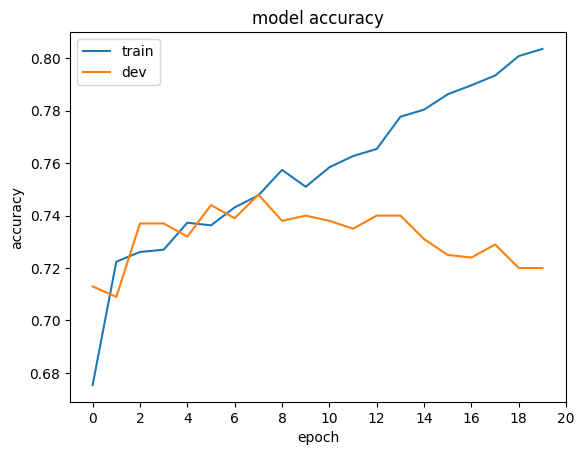

In [111]:
# summarize history for accuracy
plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.xticks([x_tick for x_tick in range(0,len(history3.history['categorical_accuracy'])+2,2)])
plt.show()

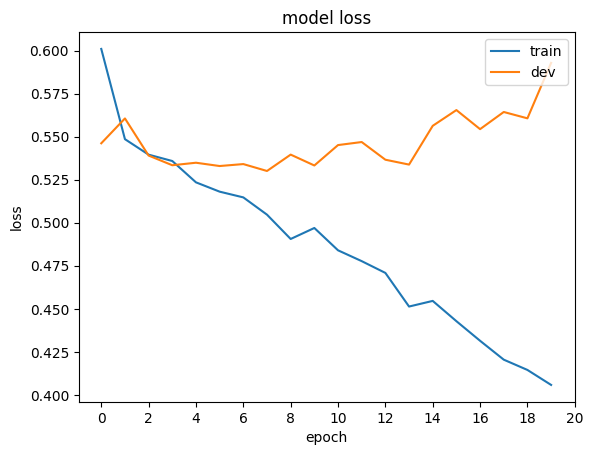

In [112]:
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.xticks([x_tick for x_tick in range(0,len(history3.history['categorical_accuracy'])+2,2)])
plt.show()

In [113]:
# Convert the test data into the required format
test_data = np.array([[" ".join(x_test)] for x_test in X_test_tokenized])

In [115]:
# Use the trained RNN model to make predictions on the training data
# The model's predict method returns a probability for each class
# We use argmax to get the index of the highest probability, which gives us the predicted class
predictions_train_rnn = np.argmax(model3.predict(train_data.astype(object)), -1)

# Make predictions on the validation data
predictions_val_rnn = np.argmax(model3.predict(val_data.astype(object)), -1)

# Make predictions on the test data
predictions_test_rnn = np.argmax(model3.predict(test_data.astype(object)), -1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 50s 229ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step


In [116]:
# Print the classification report for the training data
# The classification report shows key classification metrics including precision, recall and f1-score
print("Classification Report for TRAIN data set:")
print(classification_report(y_train_new, predictions_train_rnn))

Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      3499
           1       0.85      0.87      0.86      3501

    accuracy                           0.86      7000
   macro avg       0.86      0.86      0.86      7000
weighted avg       0.86      0.86      0.86      7000



In [117]:
# Print the classification report for the validation data
print("Classification Report for Validation data set:")
print(classification_report(y_val, predictions_val_rnn))

Classification Report for Validation data set:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       521
           1       0.70      0.72      0.71       479

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



In [118]:
# Print the classification report for the test data
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test_rnn))

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       980
           1       0.73      0.75      0.74      1020

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



#### Hyperparameter tuning for RNN GRU model

In [121]:
locale.getpreferredencoding = lambda: "UTF-8"

In [122]:
def build_model(hp):
    # Initialize a Sequential model
    model = Sequential()

    # Add an Input layer that accepts a string
    model.add(Input(shape=(1,), dtype=tf.string))

    # Add a vectorizer layer to convert the string into integer tokens
    model.add(vectorizer)

    # Add an Embedding layer to convert the integer tokens into dense vectors
    # The weights of the Embedding layer are initialized with a pre-trained embedding (GloVe)
    model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

    # Add a Dropout layer to prevent overfitting
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.1,0.2,0.3,0.4,0.5])))

    # Add a variable number of Bidirectional GRU layers
    for i in range(hp.Int(name='num_rnn_layers',min_value=1,max_value=3)):
        model.add(Bidirectional(GRU(hp.Int('gru_units', min_value=128, max_value=512, step=64), return_sequences=True)))

    # Add a Self-Attention layer
    model.add(SelfAttention(mlp_layers=hp.Int('attention_layers',1,3),
                            units=hp.Int('attention_units',min_value=128,max_value=512,step=64),
                            dropout_rate=hp.Choice('attention_dropout', values=[0.1,0.2,0.3,0.4,0.5]) ))

    # Add a Dense layer with ReLU activation
    model.add(Dense(units=hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu' ))

    # Add another Dropout layer
    model.add(Dropout(hp.Choice('dropout_rate_dense', values=[0.1,0.2,0.3,0.4,0.5])))

    # Add the output layer with softmax activation
    model.add(Dense(len(y_train_new.unique()), activation='softmax'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    # Compile the model with categorical crossentropy loss, Adam optimizer and categorical accuracy metric
    model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=hp_learning_rate),
                  metrics=[CategoricalAccuracy()])

    # Return the constructed model
    return model

In [ ]:
# Remove the directory 'KT_dir' if it exists
!rm -r KT_dir

In [ ]:
# Initialize a RandomSearch tuner from Keras Tuner
# The tuner will search for the best hyperparameters of the model defined in the 'build_model' function
# The objective of the tuner is to maximize the validation categorical accuracy
# The tuner will perform a maximum of 10 trials
# The results of the tuner will be stored in the directory 'KT_dir' under the project name 'KT_tuning'
tuner = kt.RandomSearch(build_model,
                        objective=kt.Objective("val_categorical_accuracy", direction="max"),
                        max_trials = 10,
                        directory='KT_dir',
                        project_name='KT_tuning')

# Initialize an EarlyStopping callback
# The callback will stop the training if the validation loss does not improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
dropout_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
num_rnn_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
gru_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
attention_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
attention_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
attention_dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 64, 'sampling': 'linear'}
dropout_rate_dense (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'or

In [ ]:
# Start the hyperparameter search
# The tuner will train the model on the training data and evaluate it on the validation data
# The training will be done for a maximum of 20 epochs with a batch size of 128
# The EarlyStopping callback is used during training
tuner.search(train_data.astype(object), y_train_1_hot,
             validation_data=(val_data, y_val_1_hot), epochs=20, batch_size = 128,
             callbacks=[early_stopping])

Trial 10 Complete [00h 13m 30s]
val_categorical_accuracy: 0.7429999709129333

Best val_categorical_accuracy So Far: 0.7440000176429749
Total elapsed time: 02h 23m 13s


In [ ]:
# Print a summary of the results of the hyperparameter search
tuner.results_summary()

Results summary
Results in KT_dir/KT_tuning
Showing 10 best trials
Objective(name="val_categorical_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
dropout_rate: 0.1
num_rnn_layers: 1
gru_units: 512
attention_layers: 3
attention_units: 192
attention_dropout: 0.4
dense_units: 256
dropout_rate_dense: 0.2
learning_rate: 0.0001
Score: 0.7440000176429749

Trial 09 summary
Hyperparameters:
dropout_rate: 0.3
num_rnn_layers: 1
gru_units: 128
attention_layers: 1
attention_units: 320
attention_dropout: 0.2
dense_units: 512
dropout_rate_dense: 0.4
learning_rate: 0.0001
Score: 0.7429999709129333

Trial 06 summary
Hyperparameters:
dropout_rate: 0.4
num_rnn_layers: 1
gru_units: 384
attention_layers: 2
attention_units: 448
attention_dropout: 0.1
dense_units: 320
dropout_rate_dense: 0.5
learning_rate: 0.001
Score: 0.7419999837875366

Trial 08 summary
Hyperparameters:
dropout_rate: 0.4
num_rnn_layers: 1
gru_units: 320
attention_layers: 1
attention_units: 128
attention_dropout: 0.5
dense_u

In [ ]:
# Get best hyper-parameters setup
tuner.get_best_hyperparameters()[0].values

{'dropout_rate': 0.1,
 'num_rnn_layers': 1,
 'gru_units': 512,
 'attention_layers': 3,
 'attention_units': 192,
 'attention_dropout': 0.4,
 'dense_units': 256,
 'dropout_rate_dense': 0.2,
 'learning_rate': 0.0001}

In [ ]:
# Get the best model found during the search
best_model_2 = tuner.get_best_models(num_models=1)[0]

# Print a summary of the best model
best_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 100)          51200     
                                                                 
 dropout (Dropout)           (None, 256, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 256, 1024)        1886208   
 l)                                                              
                                                                 
 self_attention (SelfAttenti  (None, 1024)             271105    
 on)                                                             
                                                        

In [ ]:
# Use the best model to predict the class labels for the training data
# The model's predict method returns a probability for each class
# We use argmax to get the index of the highest probability, which gives us the predicted class
predictions_train_rnn = np.argmax(best_model_2.predict(df_tweet_sentiment), -1)

# Make predictions on the validation data
predictions_val_rnn = np.argmax(best_model_2.predict(val_data), -1)

# Make predictions on the test data
predictions_test_rnn= np.argmax(best_model_2.predict(test_data), -1)

In [ ]:
# Print a classification report for the training data
# The classification report shows key classification metrics including precision, recall and f1-score
print("Classification Report for TRAIN data set:")
print(classification_report(y_train_new, predictions_train_rnn))

# Print a classification report for the validation data
print("Classification Report for Validation data set:")
print(classification_report(y_val, predictions_val_rnn))

# Print a classification report for the test data
print("Classification Report for TEST data set:")
print(classification_report(y_test, predictions_test_rnn))

63/63 [==============================] - 2s 39ms/step
Classification Report for TRAIN data set:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3495
           1       0.79      0.76      0.77      3505

    accuracy                           0.77      7000
   macro avg       0.78      0.77      0.77      7000
weighted avg       0.78      0.77      0.77      7000

Classification Report for Validation data set:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       522
           1       0.73      0.74      0.74       478

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.74      0.74      0.74      1000

Classification Report for TEST data set:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       983
           1       0.75      0.73      0.74      1017

In [ ]:
# Train the best model on the training data and evaluate it on the validation data
# The training will be done for a maximum of 20 epochs with a batch size of 256
# The EarlyStopping callback is used during training to stop training if the validation loss doesn't improve for a certain number of epochs
history_val_2 = best_model_2.fit(df_tweet_sentiment, y_train_1_hot,
                                 validation_data=(val_data, y_val_1_hot),
                                 batch_size=256,
                                 epochs=20,
                                 shuffle=True,
                                 callbacks=[Metrics(valid_data=(val_data, y_val_1_hot)),
                                            early_stopping])

Epoch 1/20
32/32 [==============================] - 1s 25ms/step
 — val_f1: 0.731053 — val_precision: 0.731142 — val_recall: 0.731000
28/28 [==============================] - 43s 1s/step - loss: 0.4818 - categorical_accuracy: 0.7650 - val_loss: 0.5299 - val_categorical_accuracy: 0.7320 - val_f1: 0.7311 - val_recall: 0.7310 - val_precision: 0.7311
Epoch 2/20
32/32 [==============================] - 1s 26ms/step
 — val_f1: 0.734874 — val_precision: 0.738891 — val_recall: 0.735000
28/28 [==============================] - 27s 963ms/step - loss: 0.4791 - categorical_accuracy: 0.7694 - val_loss: 0.5354 - val_categorical_accuracy: 0.7350 - val_f1: 0.7349 - val_recall: 0.7350 - val_precision: 0.7389
Epoch 3/20
32/32 [==============================] - 1s 24ms/step
 — val_f1: 0.732091 — val_precision: 0.732329 — val_recall: 0.732000
28/28 [==============================] - 34s 1s/step - loss: 0.4798 - categorical_accuracy: 0.7667 - val_loss: 0.5284 - val_categorical_accuracy: 0.7320 - val_f1: 0.

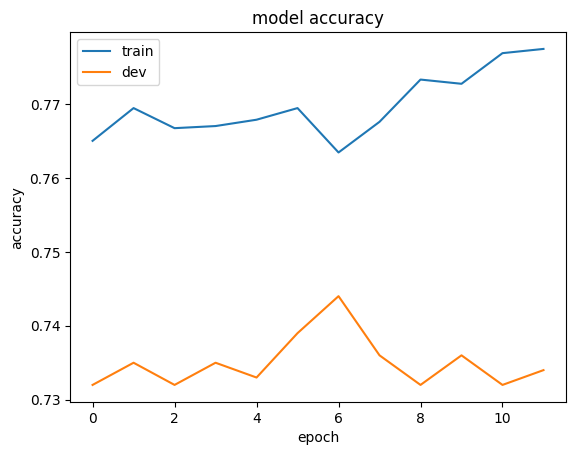

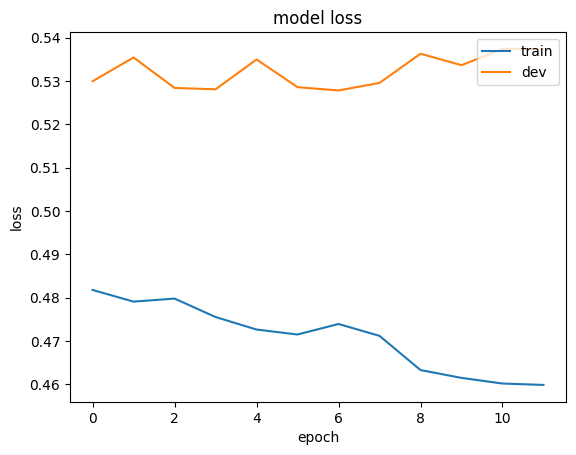

In [ ]:
# summarize history for accuracy
plt.plot(history_val_2.history['categorical_accuracy'])
plt.plot(history_val_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_val_2.history['loss'])
plt.plot(history_val_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

# Precision-Recall curves

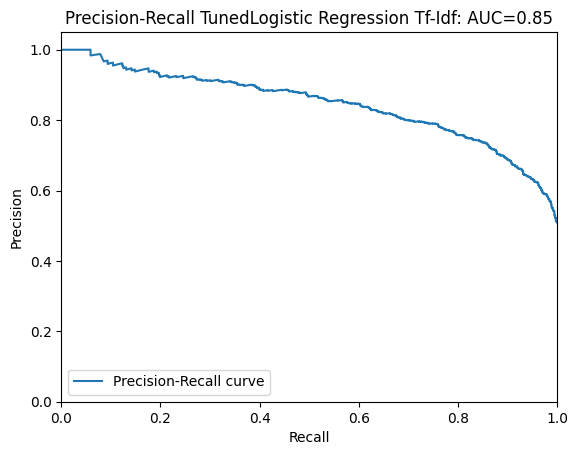

In [ ]:
#disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')
name = 'TunedLogistic Regression Tf-Idf'
model = log_cv
model.fit(x_train_tfidf, y_train)
pred = model.predict_proba(x_test_tfidf)
precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
area = auc(recall, precision)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
plt.legend(loc="lower left")
plt.show()

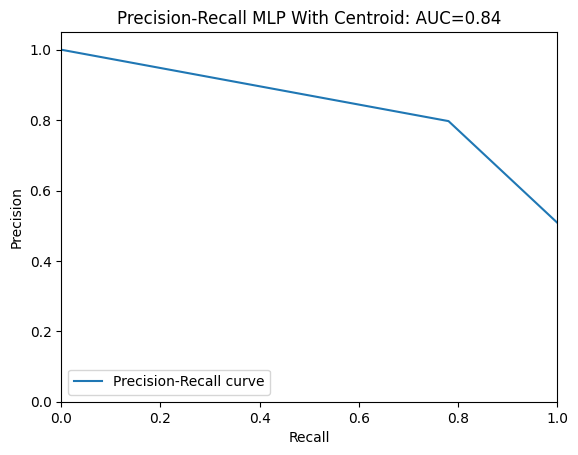

In [ ]:
#disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')
name = 'MLP With Centroid'
model = model2
pred = predictions
precision, recall, thresholds = precision_recall_curve(y_test, pred)
area = auc(recall, precision)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
plt.legend(loc="lower left")
plt.show()

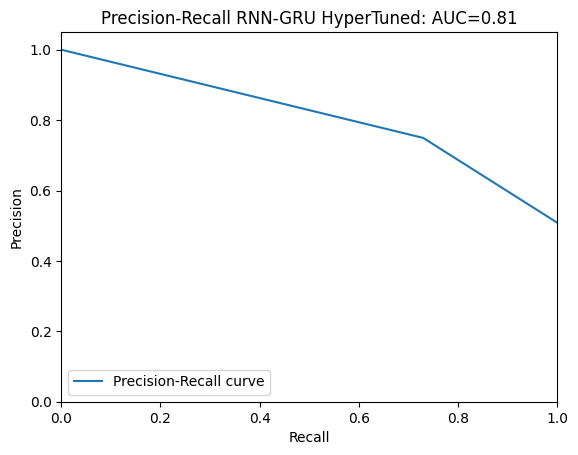

In [ ]:
#disable warnings for large float numbers of estimated probabilities
np.seterr(all='ignore')
name = 'RNN-GRU HyperTuned'
model = best_model_2
pred = predictions_test_rnn
precision, recall, thresholds = precision_recall_curve(y_test, pred)
area = auc(recall, precision)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
plt.legend(loc="lower left")
plt.show()